## Set up the environment

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from src.plotting import trim_axs
pd.set_option('display.max_rows', None)


In [2]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling'
interim_dir = f'{top_dir}/data/interim'

## Model comparisons

In [10]:
scores = []

files = glob(f'{interim_dir}/VisionEncoding/*.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0]
    scores.append(df)

files = glob(f'{interim_dir}/LLMEncoding/*orig_ordered.csv')
files += glob(f'{interim_dir}/LLMEncoding/*None.csv')
files += glob(f'{interim_dir}/LLMEncoding/*none.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('_perturb')[0]
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['model_uid', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  \
model_uid               model_layer_index stream_name                   
model-bert-base-uncased 1                 EVC           Embedding-2-1   
                                          EVC           Embedding-2-1   
                                          EVC           Embedding-2-1   
                                          EVC           Embedding-2-1   
                                          high_lateral  Embedding-2-1   

                                                        subj_id     score  \
model_uid               model_layer_index stream_name                       
model-bert-base-uncased 1                 EVC                 1  0.022819   
                                          EVC                 2  0.108643   
                                          EVC                 3  0.058795   
                                          EVC                 4  0.089968   
                                          high_lateral        1  0.120455   

                                                       method  
model_uid               model_layer_index stream_name          
model-bert-base-uncased 1                 EVC           ridge  
                                          EVC           ridge  
                                          EVC           ridge  
                                          EVC           ridge  
                                          high_lateral  ridge

In [11]:
avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['model_uid', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['model_uid', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_48332/783651595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()


,model_uid,model_layer_index,stream_name,model_layer,subj_id,score,method
0,model-bert-base-uncased,20,EVC,Dropout-6-13,1,0.103087,ridge
1,model-bert-base-uncased,20,EVC,Dropout-6-13,2,0.156122,ridge
2,model-bert-base-uncased,20,EVC,Dropout-6-13,3,0.122435,ridge
3,model-bert-base-uncased,20,EVC,Dropout-6-13,4,0.118127,ridge
4,model-bert-base-uncased,14,high_lateral,LayerNorm-5-7,1,0.160835,ridge


In [12]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

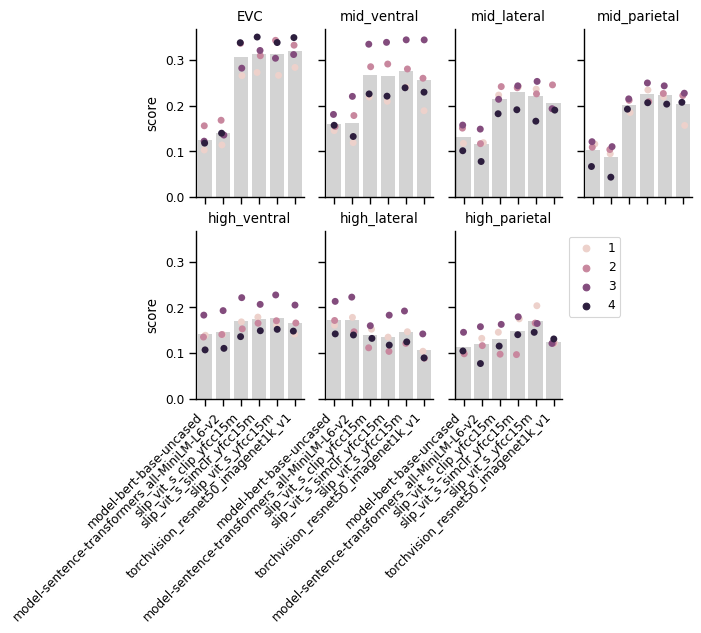

In [13]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
models = max_scores.model_uid.unique()
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='model_uid', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='model_uid', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(models, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## GLoVe perturbation experiments

In [7]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
perturbations = ['orig_shuffled',
                 'excverb_shuffled', 'excnoun_shuffled',
                 'verb_shuffled', 'noun_shuffled']

In [8]:
scores = []
for perturb in perturbations:
    file = f'{interim_dir}/GLoVeEncoding/{perturb}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores.set_index(['perturbation', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.reset_index(inplace=True)
scores.head()

cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
scores['stream_name'] = scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
scores['perturbation'] = scores['perturbation'].astype(cat_type)

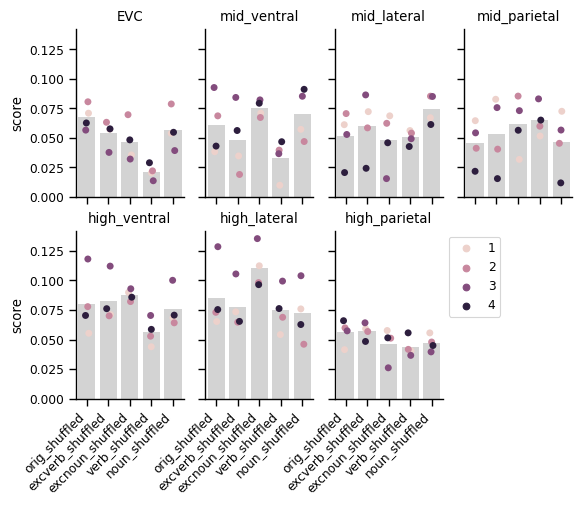

In [9]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## SBERT perturbation experiments

In [10]:
perturbations = ['orig_ordered', 'orig_shuffled',
                 'excverb_shuffled', 'excnoun_shuffled',
                 'verb_shuffled', 'noun_shuffled']

In [11]:
scores = []
for perturb in perturbations:
    file = f'{interim_dir}/LLMEncoding/model-sentence-transformers_all-MiniLM-L6-v2_perturbation-{perturb}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['perturbation', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  subj_id  \
perturbation     model_layer_index stream_name                           
excnoun_shuffled 1                 EVC           BertModel-S1        1   
                                   EVC           BertModel-S1        2   
                                   EVC           BertModel-S1        3   
                                   EVC           BertModel-S1        4   
                                   high_lateral  BertModel-S1        1   

                                                    score method  
perturbation     model_layer_index stream_name                    
excnoun_shuffled 1                 EVC           0.047756  ridge  
                                   EVC           0.042140  ridge  
                                   EVC           0.067234  ridge  
                                   EVC           0.052217  ridge  
                                   high_lateral  0.116355  ridge

In [12]:
avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['perturbation', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['perturbation', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_40607/37540273.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()


,perturbation,model_layer_index,stream_name,model_layer,subj_id,score,method
0,excnoun_shuffled,55,EVC,LayerNorm-6-21,1,0.092569,ridge
1,excnoun_shuffled,55,EVC,LayerNorm-6-21,2,0.093562,ridge
2,excnoun_shuffled,55,EVC,LayerNorm-6-21,3,0.102722,ridge
3,excnoun_shuffled,55,EVC,LayerNorm-6-21,4,0.086276,ridge
4,excnoun_shuffled,11,high_lateral,BertSelfAttention-5-1,1,0.145176,ridge


In [13]:
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
max_scores['perturbation'] = max_scores['perturbation'].astype(cat_type)

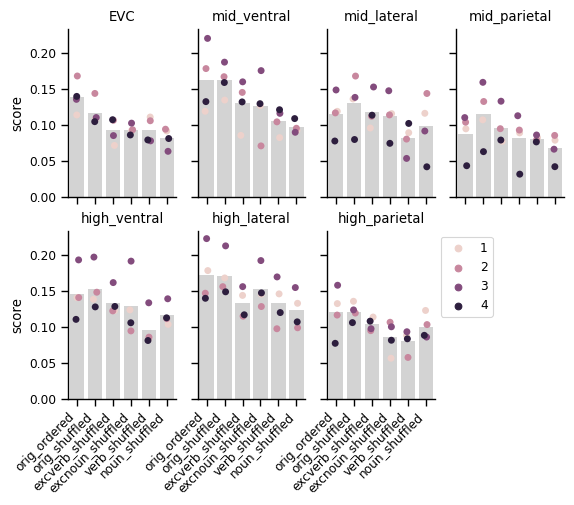

In [14]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()